<a href="https://colab.research.google.com/gist/Justinezgh/75ee6fbd05c999f81b2d18d61f4fc308/tuto_npe_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet sbibm dm-haiku
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet chainconsumer==0.34.0

In [2]:
import sbibm
import jax
import jax.numpy as jnp
import sbi_lens
from functools import partial
import haiku as hk
import optax

# Simulation model

In [3]:
# you can choose any simulation model
sbibm.get_available_tasks()

['slcp',
 'gaussian_linear_uniform',
 'two_moons',
 'bernoulli_glm',
 'lotka_volterra',
 'gaussian_mixture',
 'sir',
 'gaussian_linear',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [4]:
task = sbibm.get_task("gaussian_linear")
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0] # the dimensionality of the params space

# Neural Posterior Estimation

In [5]:
# Create neural density estimator (NDE) to approximate p(theta | y)
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP

# Affine bijection used in the RealNVP coupling
bijector_npe = partial(
  AffineCoupling,
  layers=[128] * 2,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_npe = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_npe
)


# log probability of the NDE
nvp_nd = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_npe(dim)(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nvp_sample_nd = hk.transform(
  lambda y : NF_npe(dim)(y).sample(100_000, seed=hk.next_rng_key())
)

In [9]:
# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nvp_nd.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [10]:
# init nf params
params = nvp_nd.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.ones([1, dim]),
    0.5 * jnp.ones([1, dim])
)

# define optimizer
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

In [11]:
# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
pbar = tqdm(range(5_000))

for batch in pbar:
  thetas = prior(num_samples=batch_size)
  xs = simulator(thetas)

  l, params, opt_state = update(
      params,
      opt_state,
      jnp.array(thetas),
      jnp.array(xs),
  )
  batch_loss.append(l)
  pbar.set_description(f"loss {l:.3f}")

loss -0.760: 100%|██████████| 5000/5000 [01:13<00:00, 67.63it/s]


Populating the interactive namespace from numpy and matplotlib


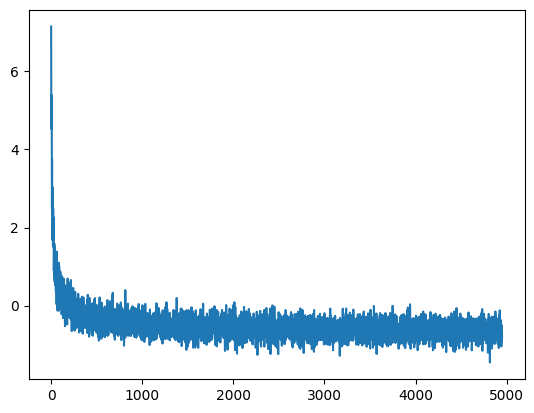

In [12]:
%pylab inline
plt.plot(batch_loss[50:])

# Results

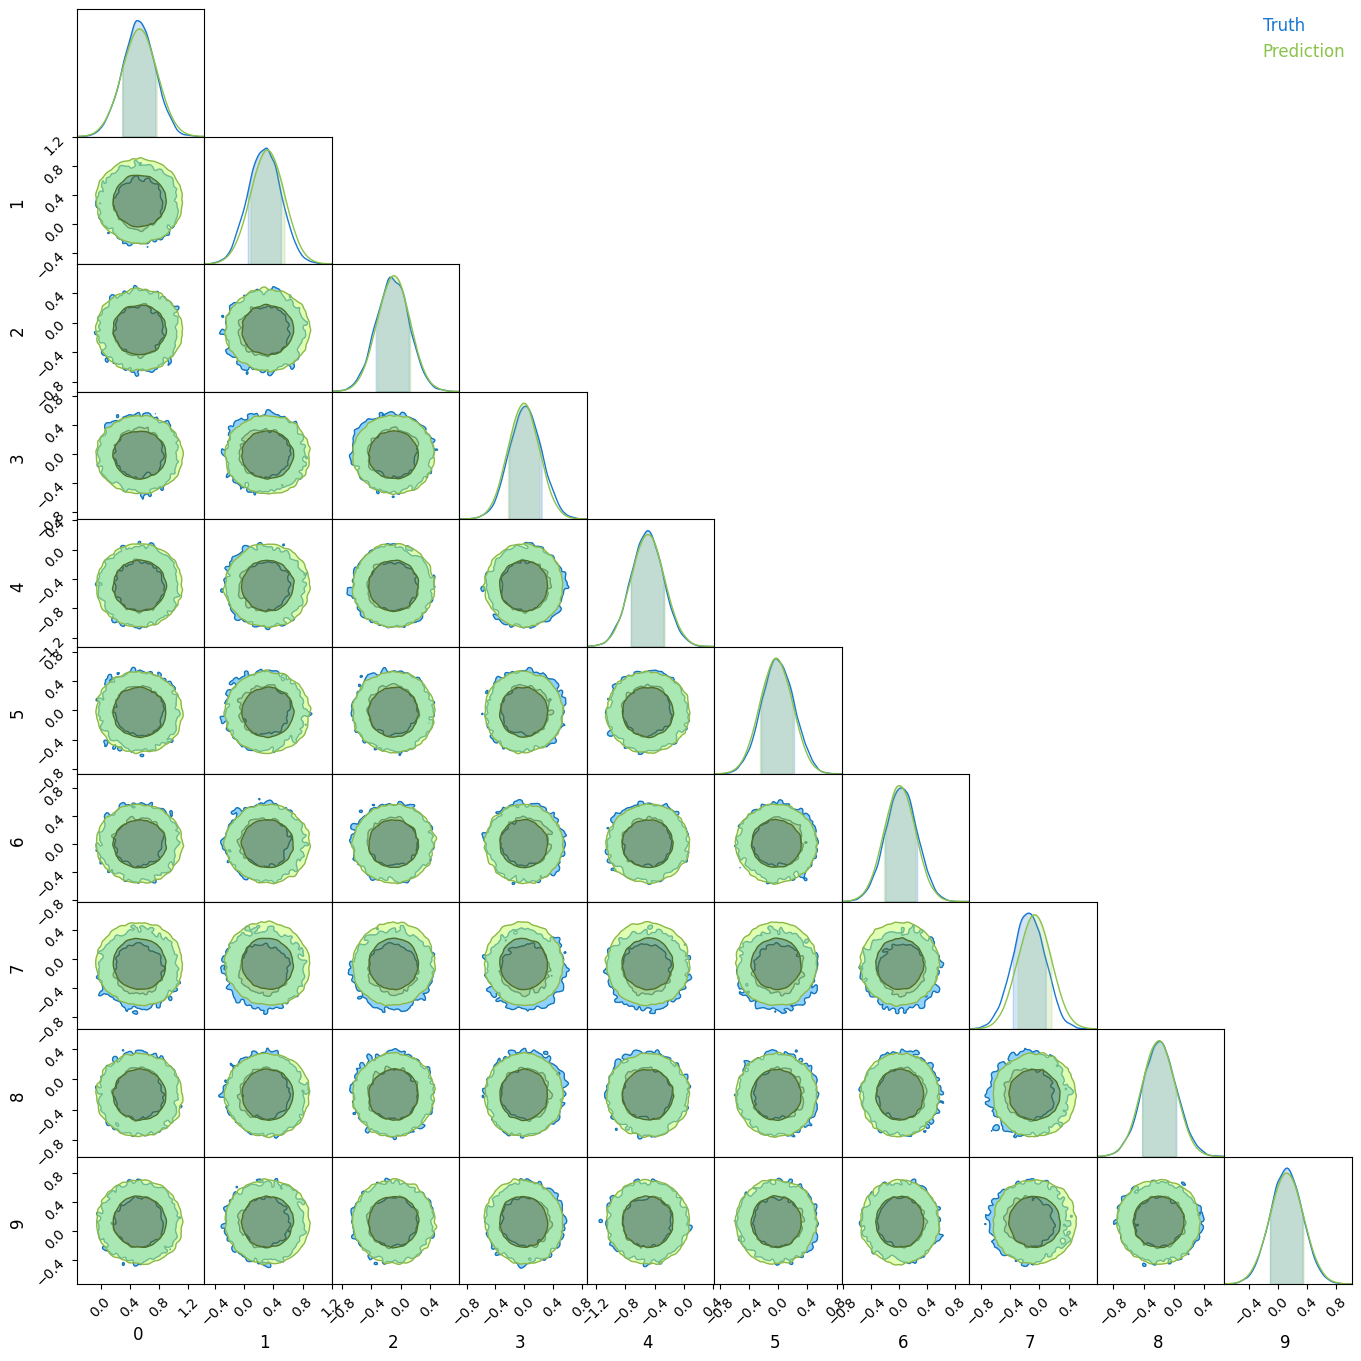

In [13]:
from chainconsumer import ChainConsumer

# plot infered params
sample_nd = nvp_sample_nd.apply(
      params,
      rng = jax.random.PRNGKey(43),
      y = observation * jnp.ones([100_000, dim])
)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(sample_nd,  shade_alpha = 0.5, name='Prediction')
fig = c.plotter.plot(figsize=1.)